# ResNeXT Experiment Notebook
summary_goes_here

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as T
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

**Making sure the GPU is available for increased speed for computations**

In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## Preparing The Dataset
We run the first cell to initialize our dataloader with our dataset, but also to find the mean and standard deviation inside the images of the dataset in order to normalize the dataset correctly.

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    # No resizing
    # No normalization for now
])

# Define paths to your train, val, and test folders
train_path = './archive/train'
val_path = './archive/test'
test_path = './archive/test'

# Create dataset instances
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Calculate mean and std for normalization
mean = [0., 0., 0.]
std = [0., 0., 0.]
for img, _ in train_dataset:
    for i in range(3):  # Iterate over channels
        mean[i] += img[i, :, :].mean()
        std[i] += img[i, :, :].std()

num_samples = len(train_dataset)
for i in range(3):  # Calculate mean and std per channel
    mean[i] /= num_samples
    std[i] /= num_samples

print(f"mean: {mean}")
print(f"std: {std}")

# Define transformations with calculated mean and std for normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize images
])

# Apply the new transformation to the datasets
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

mean: [tensor(0.5077), tensor(0.5077), tensor(0.5077)]
std: [tensor(0.2120), tensor(0.2120), tensor(0.2120)]


In [4]:
# Define paths to your train, val, and test folders
train_path = './archive/train'
val_path = './archive/test'
test_path = './archive/test'

# Define transformations with calculated mean and std for normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5077, 0.5077, 0.5077), (0.2120, 0.2120, 0.2120))  # Normalize images
])

# Apply the new transformation to the datasets
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Define batch size
batch_size = 64

# Create data loaders
loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Function Definitions

In [5]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def check_accuracy_part34(loader, model):
    if loader.dataset:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for (x, y) in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_part34(model, optimizer, epochs=1):
    """
    Train a model on FER-2013 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: The accuracy of the model
    """
    #print(f"print_every: {print_every}")
    loss_list = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            loss_list.append(loss.item())
            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            # print(f"t+1: {t+1}")
            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(loader_test, model)
                print()        
    # Plotting the loss history during the training
    plt.plot(loss_list)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Plot of Loss Over Iterations')
    plt.show()
    return check_accuracy_part34(loader_test, model)


# Experiment Starts Here

Epoch 0, Iteration 100, loss = 1.7336
Checking accuracy on test set
Got 1774 / 7178 correct (24.71)

Epoch 0, Iteration 200, loss = 1.8347
Checking accuracy on test set
Got 1774 / 7178 correct (24.71)

Epoch 0, Iteration 300, loss = 1.8498
Checking accuracy on test set
Got 1764 / 7178 correct (24.58)

Epoch 0, Iteration 400, loss = 1.8169
Checking accuracy on test set
Got 1772 / 7178 correct (24.69)

Epoch 1, Iteration 100, loss = 1.8402
Checking accuracy on test set
Got 1775 / 7178 correct (24.73)

Epoch 1, Iteration 200, loss = 1.7818
Checking accuracy on test set
Got 1774 / 7178 correct (24.71)

Epoch 1, Iteration 300, loss = 1.7796
Checking accuracy on test set
Got 1752 / 7178 correct (24.41)

Epoch 1, Iteration 400, loss = 1.7983
Checking accuracy on test set
Got 1812 / 7178 correct (25.24)

Epoch 2, Iteration 100, loss = 1.8508
Checking accuracy on test set
Got 1970 / 7178 correct (27.44)

Epoch 2, Iteration 200, loss = 1.7438
Checking accuracy on test set
Got 2082 / 7178 correct

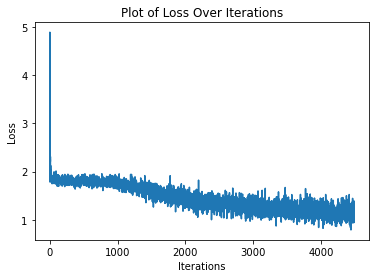

Checking accuracy on test set
Got 4048 / 7178 correct (56.39)


In [27]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(5, 5), stride=2, padding=3)
        self.bn1 = nn.GroupNorm(1, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.GroupNorm(1, 64),
            nn.ELU(),
            nn.Dropout(0.2)
        )
        self.conv3_x = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.GroupNorm(1, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.conv4_x = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.conv5_x = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=2, padding=1),
            nn.GroupNorm(1, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.final_x = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 7)
        )      
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        scores = self.final_x(x)
        return scores

model = CustomNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print_every = 100
train_part34(model, optimizer, epochs=10)
print_every = 100

Epoch 0, Iteration 100, loss = 0.9236
Checking accuracy on test set
Got 4037 / 7178 correct (56.24)

Epoch 0, Iteration 200, loss = 1.2430
Checking accuracy on test set
Got 4045 / 7178 correct (56.35)

Epoch 0, Iteration 300, loss = 1.0468
Checking accuracy on test set
Got 4041 / 7178 correct (56.30)

Epoch 0, Iteration 400, loss = 1.2288
Checking accuracy on test set
Got 4028 / 7178 correct (56.12)

Epoch 1, Iteration 100, loss = 0.8807
Checking accuracy on test set
Got 4045 / 7178 correct (56.35)

Epoch 1, Iteration 200, loss = 1.2794
Checking accuracy on test set
Got 4045 / 7178 correct (56.35)

Epoch 1, Iteration 300, loss = 1.1015
Checking accuracy on test set
Got 4041 / 7178 correct (56.30)

Epoch 1, Iteration 400, loss = 1.1509
Checking accuracy on test set
Got 4034 / 7178 correct (56.20)

Epoch 2, Iteration 100, loss = 1.1871
Checking accuracy on test set
Got 4038 / 7178 correct (56.26)

Epoch 2, Iteration 200, loss = 1.0615
Checking accuracy on test set
Got 4042 / 7178 correct

Epoch 20, Iteration 200, loss = 1.2476
Checking accuracy on test set
Got 4041 / 7178 correct (56.30)

Epoch 20, Iteration 300, loss = 1.2308
Checking accuracy on test set
Got 4045 / 7178 correct (56.35)

Epoch 20, Iteration 400, loss = 1.1285
Checking accuracy on test set
Got 4055 / 7178 correct (56.49)

Epoch 21, Iteration 100, loss = 0.9150
Checking accuracy on test set
Got 4049 / 7178 correct (56.41)

Epoch 21, Iteration 200, loss = 1.3221
Checking accuracy on test set
Got 4040 / 7178 correct (56.28)

Epoch 21, Iteration 300, loss = 1.0569
Checking accuracy on test set
Got 4045 / 7178 correct (56.35)

Epoch 21, Iteration 400, loss = 0.9811
Checking accuracy on test set
Got 4041 / 7178 correct (56.30)

Epoch 22, Iteration 100, loss = 1.1914
Checking accuracy on test set
Got 4048 / 7178 correct (56.39)

Epoch 22, Iteration 200, loss = 1.1454
Checking accuracy on test set
Got 4048 / 7178 correct (56.39)

Epoch 22, Iteration 300, loss = 1.1448
Checking accuracy on test set
Got 4037 / 71

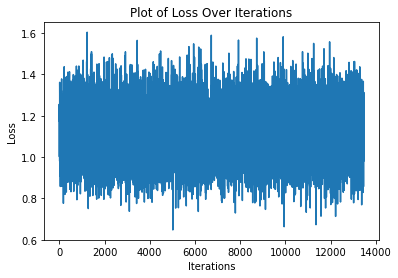

Checking accuracy on test set
Got 4040 / 7178 correct (56.28)


In [28]:
model2 = CustomNet()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

print_every = 100
train_part34(model, optimizer, epochs=30)
print_every = 100

In [29]:
# Checks your accuracy
best_model = model
check_accuracy_part34(loader_test, best_model)

Checking accuracy on test set
Got 4040 / 7178 correct (56.28)


0.5628308721092227